In [ ]:
import pandas as pd
import gdown
import numpy as np

class Updated_Type2_FIS:
    def __init__(self, numberOfMFInputV=5, numberOfMFInputD=5, numberOfMFOutputP=9,
                 maxOfVelocity=120, maxOfDistance=1000, maxOfPedal=45):
        self.numberOfMFInputV = numberOfMFInputV
        self.numberOfMFInputD = numberOfMFInputD
        self.numberOfMFOutputP = numberOfMFOutputP
        self.maxOfVelocity = maxOfVelocity
        self.maxOfDistance = maxOfDistance
        self.maxOfPedal = maxOfPedal
        self.data = self.load_data()

    def load_data(self):
        url = 'https://drive.google.com/uc?id=1yOYcEoNazkqLnOO0LF7I2O5u2Kcq0x16'
        file_path = 'Updated_Fuzzy_Rules.xlsx'
        gdown.download(url, file_path, quiet=True)
        data = pd.read_excel(file_path, skiprows=2, header=None, usecols="N:P")
        data.columns = ['V', 'D', 'P']
        return data

    def get_parameters_MFs(self, numberOfMFs, maxValue):
        step = maxValue / (numberOfMFs - 1)
        parameters_MFs = []
        for i in range(numberOfMFs):
            center = i * step
            width = step / 4
            parameters_MFs.append([center - width, center, center + width])
        return parameters_MFs

    def interval_triangular(self, x, params):
        a, b, c = params
        lower_membership = max(min((x - a) / (b - a), (c - x) / (c - b)), 0)
        upper_membership = min(max((x - a) / (b - a), (c - x) / (c - b)), 1)
        return (lower_membership, upper_membership)

    def inference(self, inputV, inputD):
        params_MF_Velocity = self.get_parameters_MFs(self.numberOfMFInputV, self.maxOfVelocity)
        params_MF_Distance = self.get_parameters_MFs(self.numberOfMFInputD, self.maxOfDistance)

        fuzzified_V = [self.interval_triangular(inputV, params) for params in params_MF_Velocity]
        fuzzified_D = [self.interval_triangular(inputD, params) for params in params_MF_Distance]

        output_intervals = []
        for v_degree, row in zip(fuzzified_V, self.data.iterrows()):
            _, rule = row
            for d_degree in fuzzified_D:
                lower_strength = min(v_degree[0], d_degree[0])
                upper_strength = min(v_degree[1], d_degree[1])
                output_intervals.append((lower_strength, upper_strength, rule['P']))

        if not output_intervals:
            return 0

        weighted_sum = sum(lower * pedal + upper * pedal for lower, upper, pedal in output_intervals)
        sum_strengths = sum(lower + upper for lower, upper, _ in output_intervals)

        return weighted_sum / sum_strengths if sum_strengths != 0 else 0

# Create an instance of the FIS
fis = Updated_Type2_FIS()

# Prepare a list to store the output data
output_data = []

# Process the data and apply fuzzy inference
for index, row in fis.data.iterrows():
    velocity = row['V']
    distance = row['D']
    pedal = row['P']

    velocity_index = min(int(velocity) - 1, fis.numberOfMFInputV - 1)
    distance_index = min(int(distance) - 1, fis.numberOfMFInputD - 1)

    mf_vel_params = fis.get_parameters_MFs(fis.numberOfMFInputV, fis.maxOfVelocity)[velocity_index]
    mf_dis_params = fis.get_parameters_MFs(fis.numberOfMFInputD, fis.maxOfDistance)[distance_index]

    mf_vel = fis.interval_triangular(velocity, mf_vel_params)
    mf_dis = fis.interval_triangular(distance, mf_dis_params)

    product = np.prod(mf_vel + mf_dis)  # Approximating the product of intervals
    center_pedal = fis.inference(velocity, distance)

    output_data.append({
        'Velocity': velocity,
        'Distance': distance,
        'Pedal': pedal,
        'MF_Vel': mf_vel,
        'MF_Dis': mf_dis,
        'Product': product,
        'Center_Pedal': center_pedal
    })

# Convert the list of dictionaries to a DataFrame
output_df = pd.DataFrame(output_data)

# Apply a clean, modern style with the DataFrame's `style` property
styled_df = output_df.style.set_table_styles(
    [{
        'selector': 'th',
        'props': [('font-size', '12pt'), ('background-color', 'lightgrey'), ('color', 'black')]
    },
    {
        'selector': 'td',
        'props': [('font-size', '12pt'), ('text-align', 'center')]
    }]
).background_gradient(cmap='viridis', subset=['Center_Pedal'])\
  .set_properties(**{'border': '1.5px solid black', 'border-collapse': 'collapse'})\
  .set_caption("Fuzzy Inference System Outputs")\
  .format({"Center_Pedal": "{:.2f}", "MF_Vel": str, "MF_Dis": str})\
  .bar(subset=["Pedal", "Product"], color='lightgreen')

# Display the styled DataFrame
styled_df


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3851: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Velocity,Distance,Pedal,MF_Vel,MF_Dis,Product,Center_Pedal
0,1,2,16,"(0.8666666666666667, 1)","(0, 1)",0.000000,14.07
1,1,3,15,"(0.8666666666666667, 1)","(0, 1)",0.000000,14.07
2,1,4,14,"(0.8666666666666667, 1)","(0, 1)",0.000000,14.07
3,1,5,13,"(0.8666666666666667, 1)","(0, 1)",0.000000,14.07
4,1,6,12,"(0.8666666666666667, 1)","(0, 1)",0.000000,14.07
5,1,7,11,"(0.8666666666666667, 1)","(0, 1)",0.000000,14.07
6,1,8,10,"(0.8666666666666667, 1)","(0, 1)",0.000000,14.07
7,1,9,9,"(0.8666666666666667, 1)","(0, 1)",0.000000,14.07
8,2,1,16,"(0, 1)","(0.984, 1)",0.000000,14.06
9,2,2,15,"(0, 1)","(0, 1)",0.000000,14.06


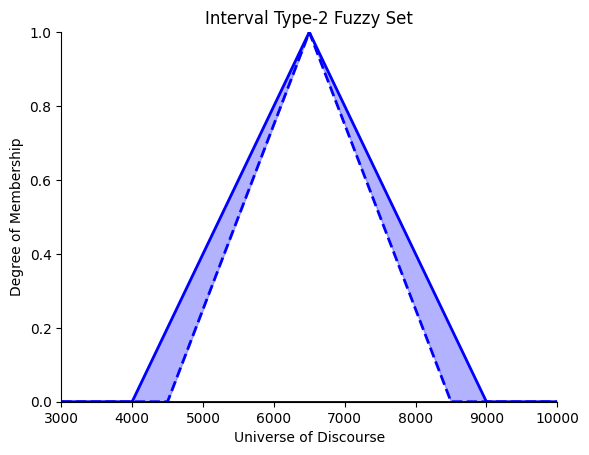

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the parameters for the triangular membership functions
params = [4000, 6500, 9000]  # Example parameters: [left, peak, right]

# Create a figure and axis
fig, ax = plt.subplots()

# Generate x values
x = np.linspace(3000, 10000, 1000)

# Upper Membership Function (UMF)
umf = np.minimum(np.maximum((x - params[0]) / (params[1] - params[0]), 0), np.maximum((params[2] - x) / (params[2] - params[1]), 0))

# Lower Membership Function (LMF)
lmf_width = (params[2] - params[0]) * 0.1  # 10% of the base width of the UMF
lmf = np.minimum(np.maximum((x - (params[0] + lmf_width)) / (params[1] - (params[0] + lmf_width)), 0), np.maximum((params[2] - lmf_width - x) / (params[2] - lmf_width - params[1]), 0))

# Fill between LMF and UMF
ax.fill_between(x, lmf, umf, color='blue', alpha=0.3)

# Plot the UMF and LMF lines
ax.plot(x, umf, 'b', linewidth=2)
ax.plot(x, lmf, 'b--', linewidth=2)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Draw a line for the x-axis
ax.axhline(0, color='black', linewidth=2)

# Set limits for x and y axes
ax.set_xlim(3000, 10000)
ax.set_ylim(0, 1)

# Label the plot
ax.set_xlabel('Universe of Discourse')
ax.set_ylabel('Degree of Membership')
ax.set_title('Interval Type-2 Fuzzy Set')

# Show the plot
plt.show()


<ipython-input-5-dc1b9204b58d>:47: RuntimeWarning: invalid value encountered in scalar divide
  upper_membership = (x - a) / (b - a)


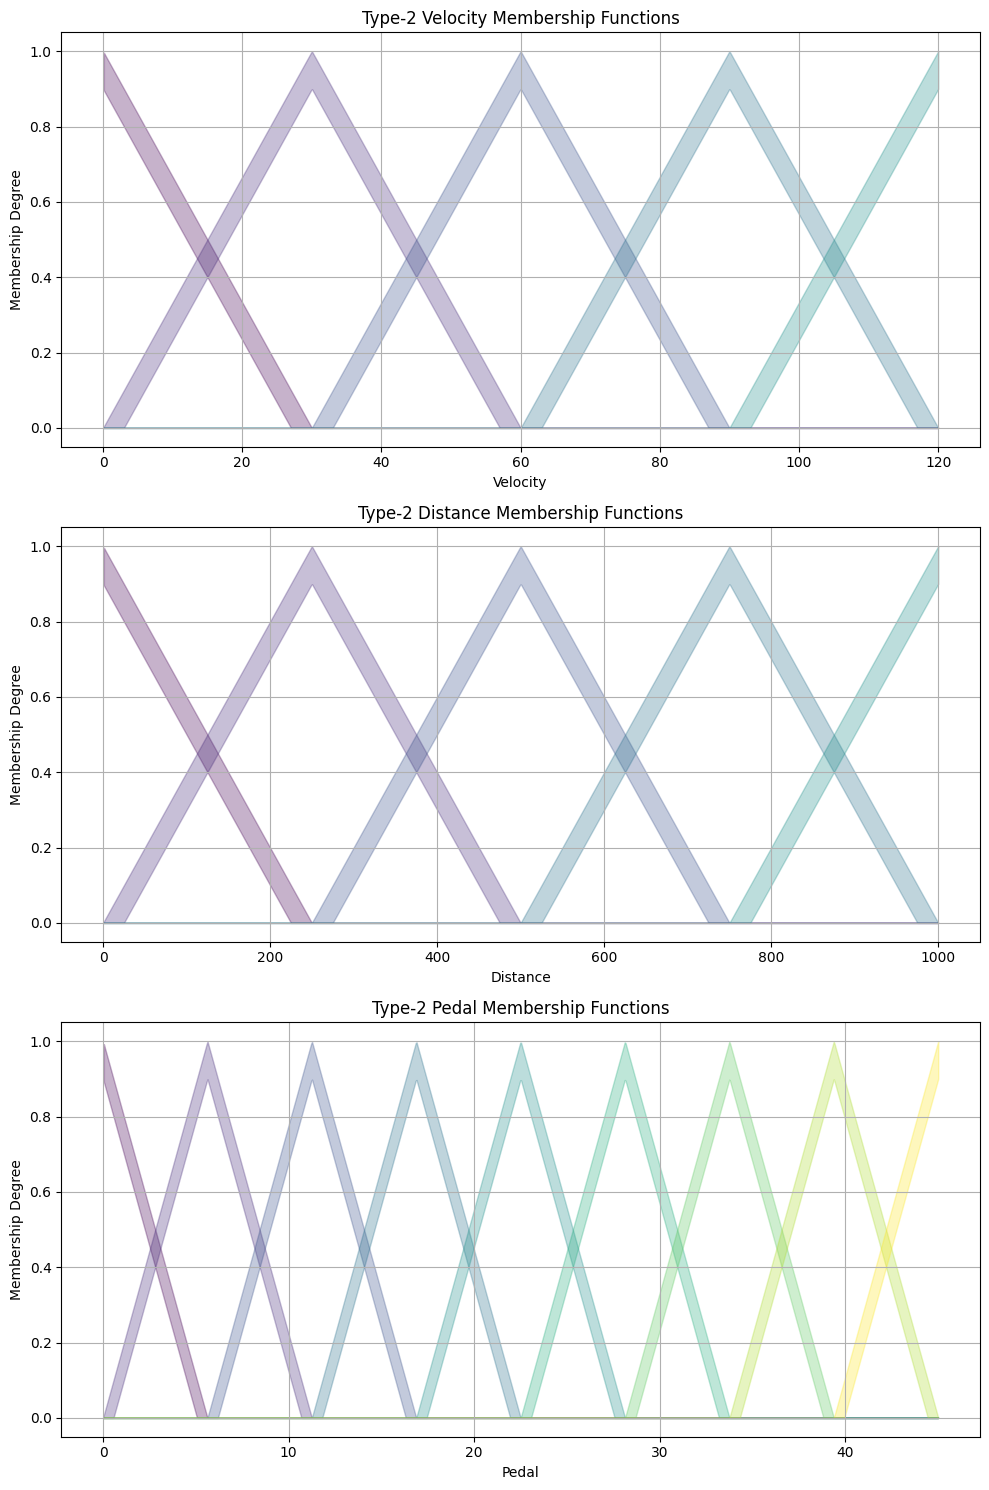

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gdown

# We'll assume the FOU is constant and given by a specific value
FOU_CONSTANT = 0.1

class Updated_Type2_FIS:
    def __init__(self, numberOfMFInputV=5, numberOfMFInputD=5, numberOfMFOutputP=9,
                 maxOfVelocity=120, maxOfDistance=1000, maxOfPedal=45):
        self.numberOfMFInputV = numberOfMFInputV
        self.numberOfMFInputD = numberOfMFInputD
        self.numberOfMFOutputP = numberOfMFOutputP
        self.maxOfVelocity = maxOfVelocity
        self.maxOfDistance = maxOfDistance
        self.maxOfPedal = maxOfPedal
        self.data = self.load_data()

    def load_data(self):
        url = 'https://drive.google.com/uc?id=1yOYcEoNazkqLnOO0LF7I2O5u2Kcq0x16'
        file_path = 'Updated_Fuzzy_Rules.xlsx'
        gdown.download(url, file_path, quiet=True)
        data = pd.read_excel(file_path, skiprows=2, header=None, usecols="N:P")
        data.columns = ['V', 'D', 'P']
        return data

    def get_parameters_MFs(self, numberOfMFs, maxValue):
        step = maxValue / (numberOfMFs - 1)
        parameters_MFs = []
        for i in range(numberOfMFs):
            if i == 0:
                parameters_MFs.append([0, 0, step])
            elif i == numberOfMFs - 1:
                parameters_MFs.append([(i - 1) * step, maxValue, maxValue])
            else:
                parameters_MFs.append([(i - 1) * step, i * step, (i + 1) * step])
        return parameters_MFs

    def triangular_type2(self, x, params):
        a, b, c = params
        lower_membership = 0.0
        upper_membership = 0.0

        # Calculate the normal upper membership value
        if a <= x <= b:
            upper_membership = (x - a) / (b - a)
        elif b < x <= c:
            upper_membership = (c - x) / (c - b)

        # Apply the constant FOU to the upper membership to get the lower membership
        lower_membership = max(0, upper_membership - FOU_CONSTANT)

        return (lower_membership, upper_membership)

    def plot_membership_functions_type2(self):
        fig, axs = plt.subplots(3, 1, figsize=(10, 15))
        colors = plt.cm.viridis(np.linspace(0, 1, max(self.numberOfMFInputV, self.numberOfMFInputD, self.numberOfMFOutputP)))

        # Plot Velocity MFs with shaded area between upper and lower MFs
        for i, params in enumerate(self.get_parameters_MFs(self.numberOfMFInputV, self.maxOfVelocity)):
            x = np.linspace(0, self.maxOfVelocity, 1000)
            y_lower, y_upper = zip(*[self.triangular_type2(xi, params) for xi in x])
            color = colors[i]
            axs[0].fill_between(x, y_lower, y_upper, color=color, alpha=0.3)
        axs[0].set_title('Type-2 Velocity Membership Functions')
        axs[0].set_xlabel('Velocity')
        axs[0].set_ylabel('Membership Degree')

        # Plot Distance MFs with shaded area between upper and lower MFs
        for i, params in enumerate(self.get_parameters_MFs(self.numberOfMFInputD, self.maxOfDistance)):
            x = np.linspace(0, self.maxOfDistance, 1000)
            y_lower, y_upper = zip(*[self.triangular_type2(xi, params) for xi in x])
            color = colors[i]
            axs[1].fill_between(x, y_lower, y_upper, color=color, alpha=0.3)
        axs[1].set_title('Type-2 Distance Membership Functions')
        axs[1].set_xlabel('Distance')
        axs[1].set_ylabel('Membership Degree')

        # Plot Pedal MFs with shaded area between upper and lower MFs
        for i, params in enumerate(self.get_parameters_MFs(self.numberOfMFOutputP, self.maxOfPedal)):
            x = np.linspace(0, self.maxOfPedal, 1000)
            y_lower, y_upper = zip(*[self.triangular_type2(xi, params) for xi in x])
            color = colors[i]
            axs[2].fill_between(x, y_lower, y_upper, color=color, alpha=0.3)
        axs[2].set_title('Type-2 Pedal Membership Functions')
        axs[2].set_xlabel('Pedal')
        axs[2].set_ylabel('Membership Degree')

        for ax in axs:
            ax.grid(True)

        plt.tight_layout()
        plt.show()

# Create an instance of the Type-2 FIS
type2_fis = Updated_Type2_FIS()

# Plot the Type-2 membership functions
type2_fis.plot_membership_functions_type2()
